#### 使用 GAN 完成人脸的生成对抗训练

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# 选择设备
# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 处理数据集

In [20]:
# 下载困难可以从网上下载
## 在相应的位置包含文件("img_align_celeba.zip", "list_attr_celeba.txt", "identity_CelebA.txt", "list_bbox_celeba.txt", "list_eval_partition.txt", "list_landmarks_align_celeba.txt")
data_path = './data/CelebA'
transform = transforms.Compose([
    transforms.CenterCrop(128),  # 这里假设裁剪为 178x178 的大小，你可以根据需要调整
    transforms.ToTensor()
])

trainset = datasets.CelebA(root=data_path,
                        split='train', 
                        download=True, 
                        transform=transform)

train_data_loader = torch.utils.data.DataLoader(
        dataset=trainset,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        pin_memory=True)

Files already downloaded and verified


In [21]:
# 查看图片维度
trainset[0][0].size()

torch.Size([3, 128, 128])

In [22]:
# next(iter(train_data_loader))[0].shape

#### 构建神经网络

In [23]:
# 鉴别器
class Discriminator(nn.Module):
    def __init__(self, learning_rate=0.0001):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.GELU(),
            nn.Flatten(0),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid(),
        ).to(device)
        # 定义损失函数
        self.loss_fun = nn.BCELoss()

        # 定义优化器
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate) # Adam优化器

        # 记录损失函数
        self.counter = 0 # 训练次数
        self.progress = [] # 损失函数值

    def forward(self, x):
        output = self.model(x)
        return output
    
    def NN_train(self, input, target):
        # 前向传播
        output = self.model(input)

        # 计算损失函数
        loss = self.loss_fun(output, target)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        # 记录损失函数
        self.counter += 1
        # 记录损失函数
        if self.counter%100==0:
            self.progress.append(loss.item())

In [24]:
# 生成器
class Generator(nn.Module):
    def __init__(self, size=100, learing_rate=0.0001):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 1*3*11*11),
            nn.GELU(),
            nn.Unflatten(0, (1, 3, 11, 11)),
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),            
            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        ).to(device)

        self.optimiser = torch.optim.Adam(self.parameters(), lr=learing_rate) # Adam优化器

        self.counter = 0 # 训练次数
        self.progress = [] # 损失函数值

    def forward(self, x):
        # 前向传播
        x = self.model(x)
        return x
    
    def NN_train(self, D, inputs, targets):
        # 前向传播
        outputs = self.model(inputs)

        # 鉴别器的输出
        D_outputs = D(outputs)

        # 计算损失函数
        loss = D.loss_fun(D_outputs, targets)

        # 清空梯度
        self.optimiser.zero_grad()
        # 反向传播
        loss.backward()
        # 更新参数
        self.optimiser.step()

        # 记录损失函数
        self.counter += 1
        if (self.counter % 10 == 0): # 每10次记录一次损失函数值
            self.progress.append(loss.item())

#### 开始训练网络

In [25]:
epochs = 15
lr = 0.0001
size = 100

right_lalel = torch.FloatTensor([1.0]).to(device)
error_lalel = torch.FloatTensor([0.0]).to(device)

In [26]:
# 构建网络实列
D = Discriminator(lr)
G = Generator(size, lr)

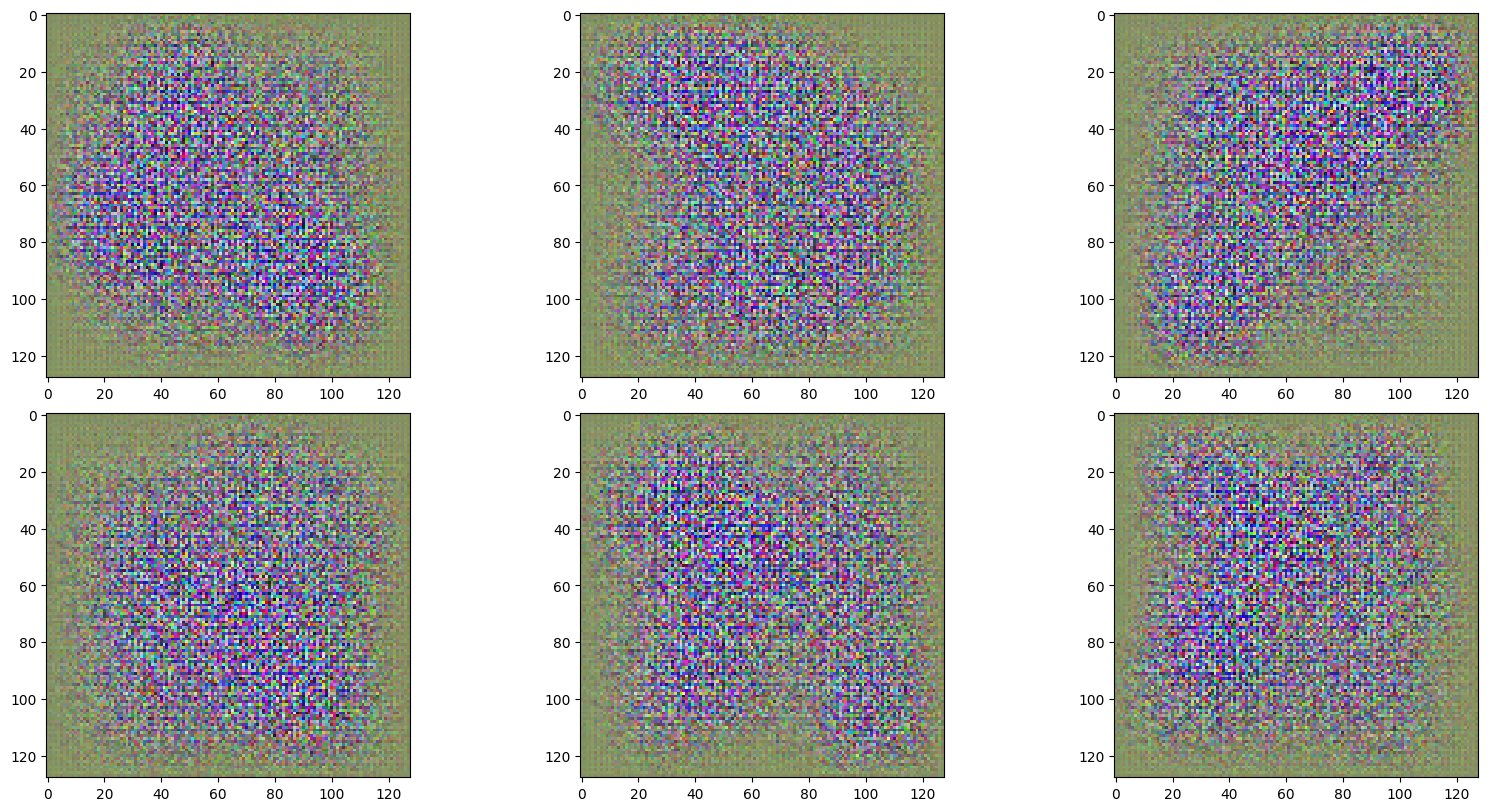

In [27]:
def plt_G():
    with torch.no_grad():
        plt.ioff
        figure, ax = plt.subplots(2, 3, figsize=(16,8), layout='constrained')
        for i in range(2):
            for j in range(3):
                g_output = G(torch.randn(size, device=device))
                g_output = g_output.detach().cpu().numpy().transpose(0, 2, 3, 1).reshape(128, 128, 3)
                ax[i,j].imshow(g_output, interpolation='none',cmap='Blues')
                
        plt.show()
plt_G()

======= 开始训练 =======

 学习进度：0.000 %

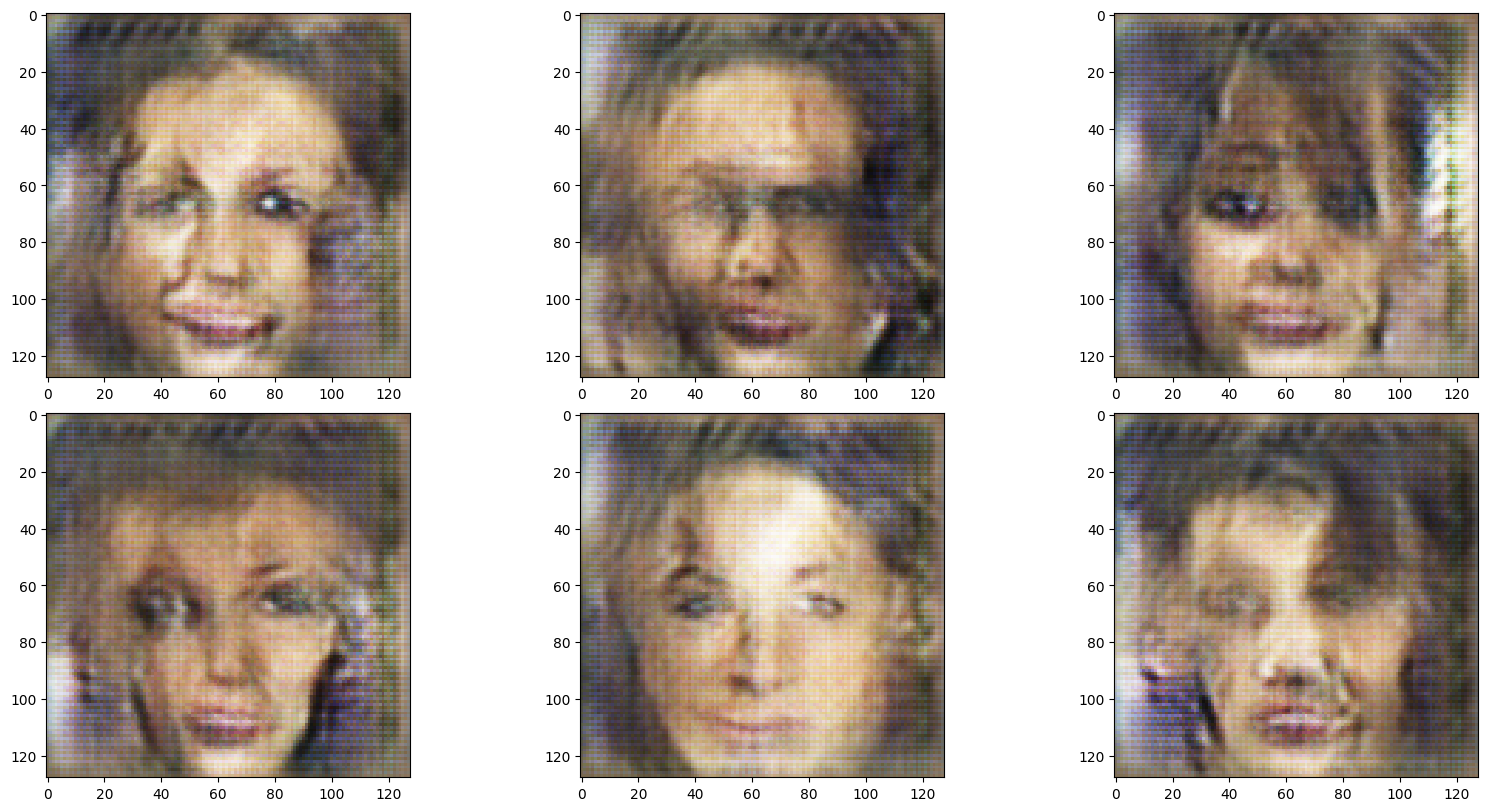

 学习进度：6.667 %

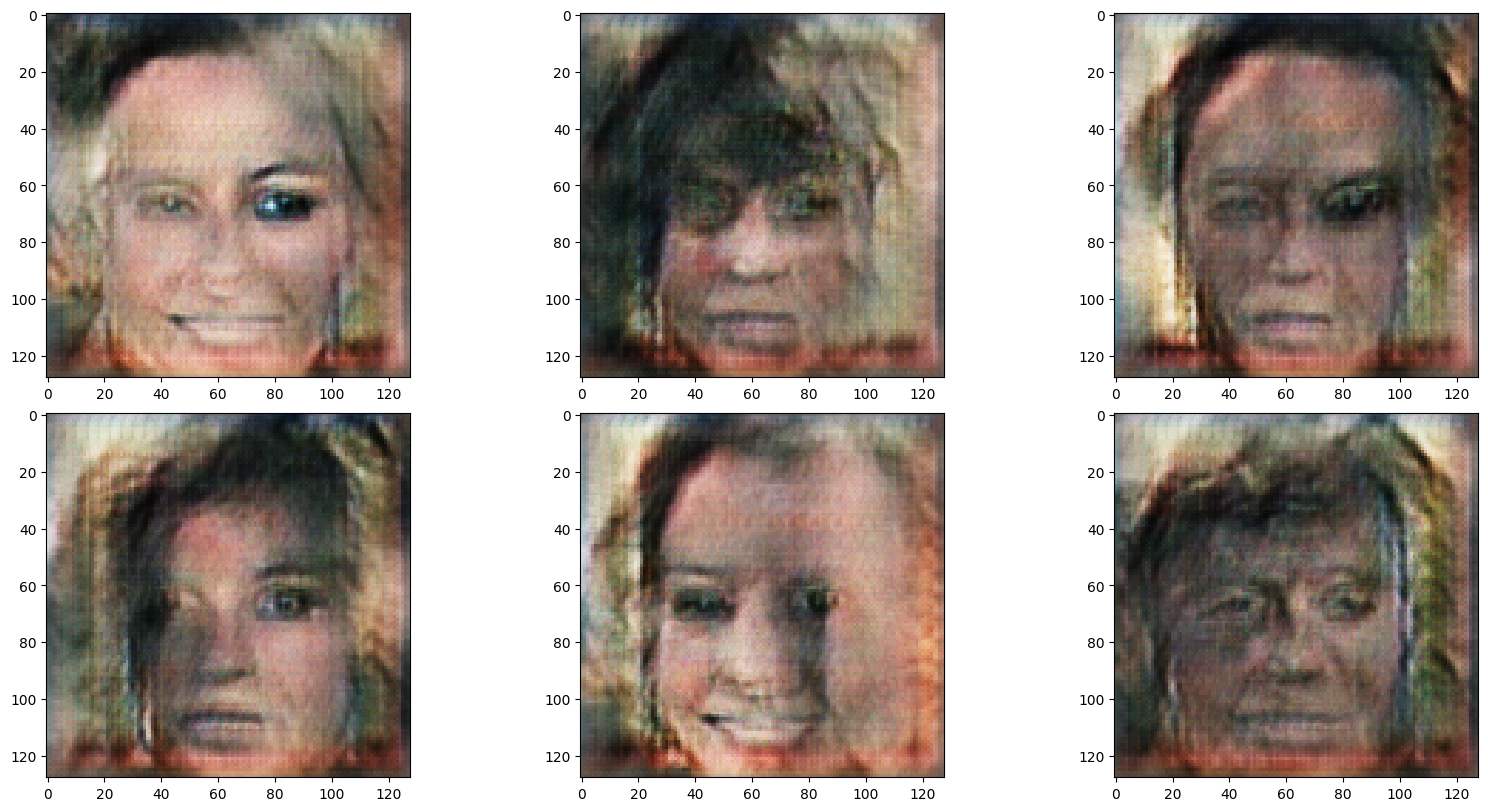

 学习进度：13.333 %

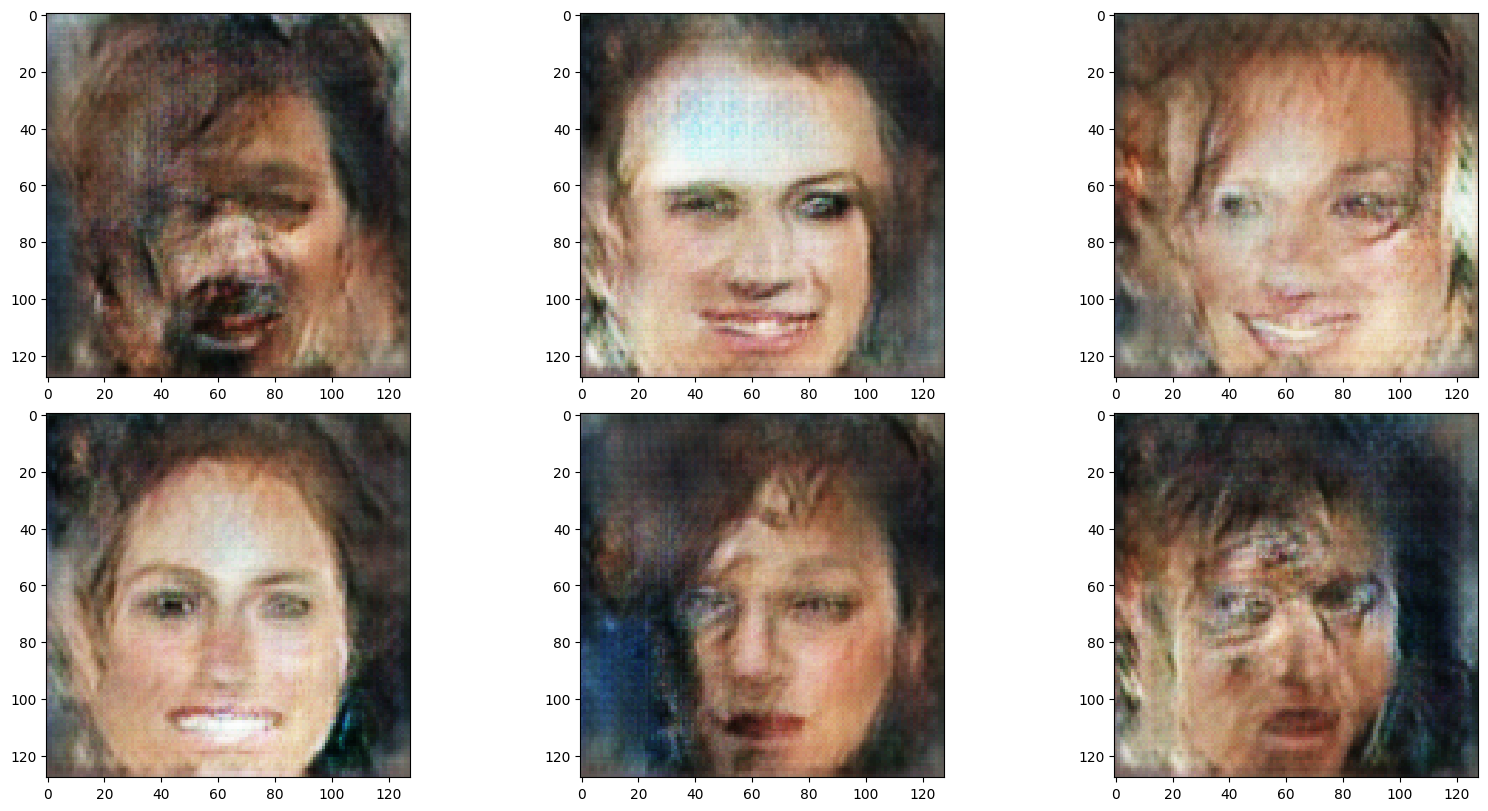

 学习进度：20.000 %

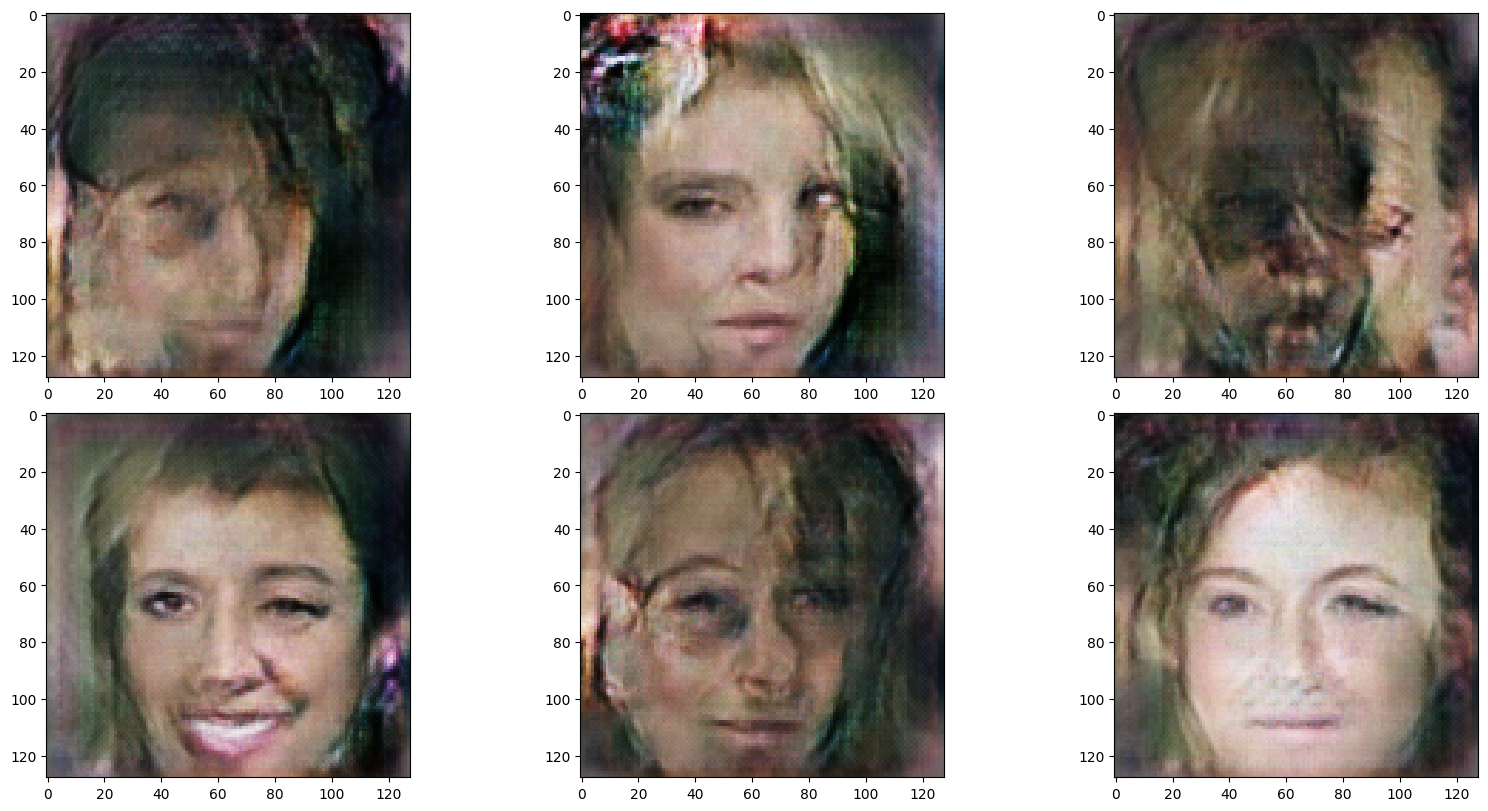

 学习进度：26.667 %

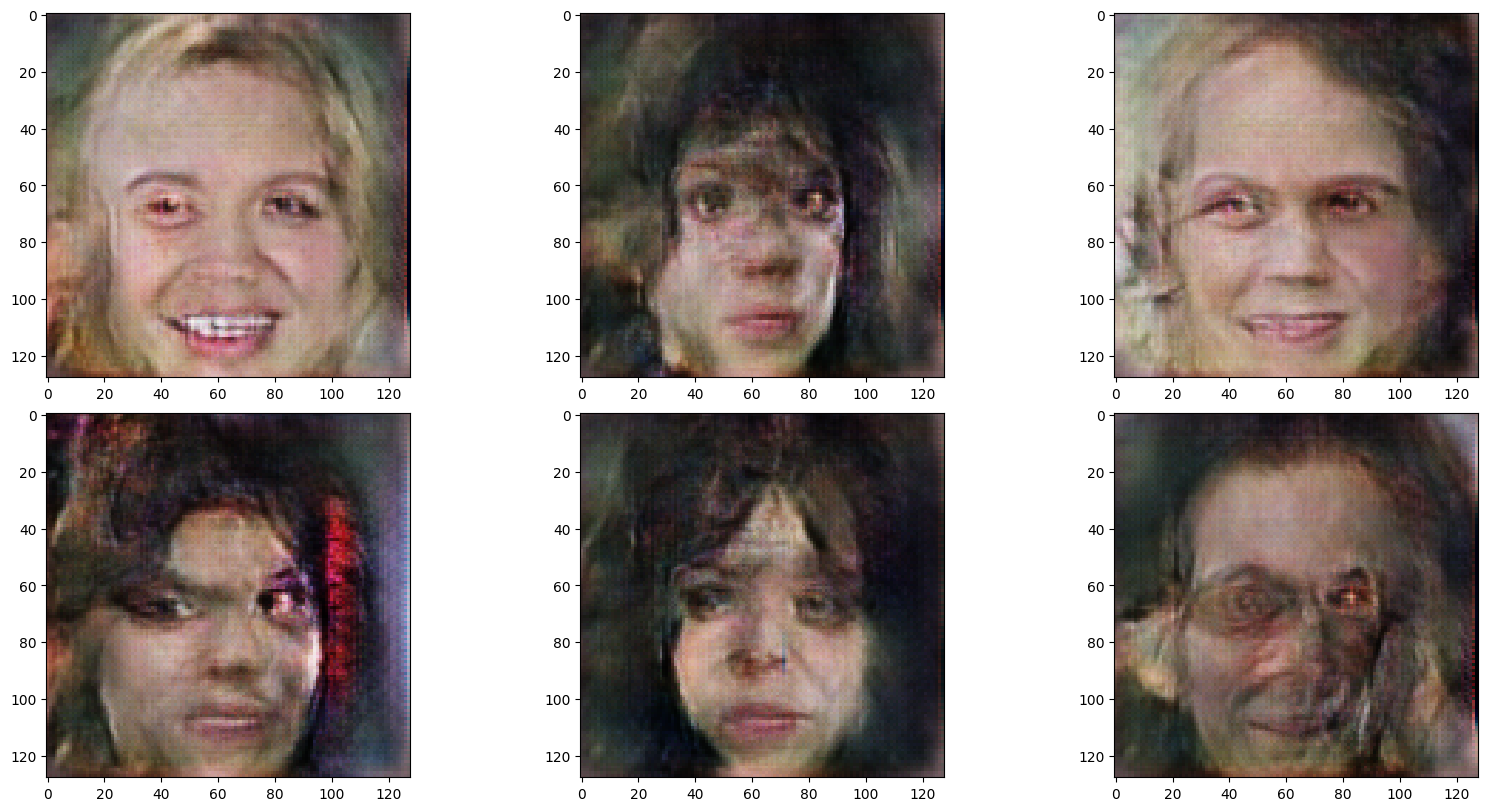

 学习进度：33.333 %

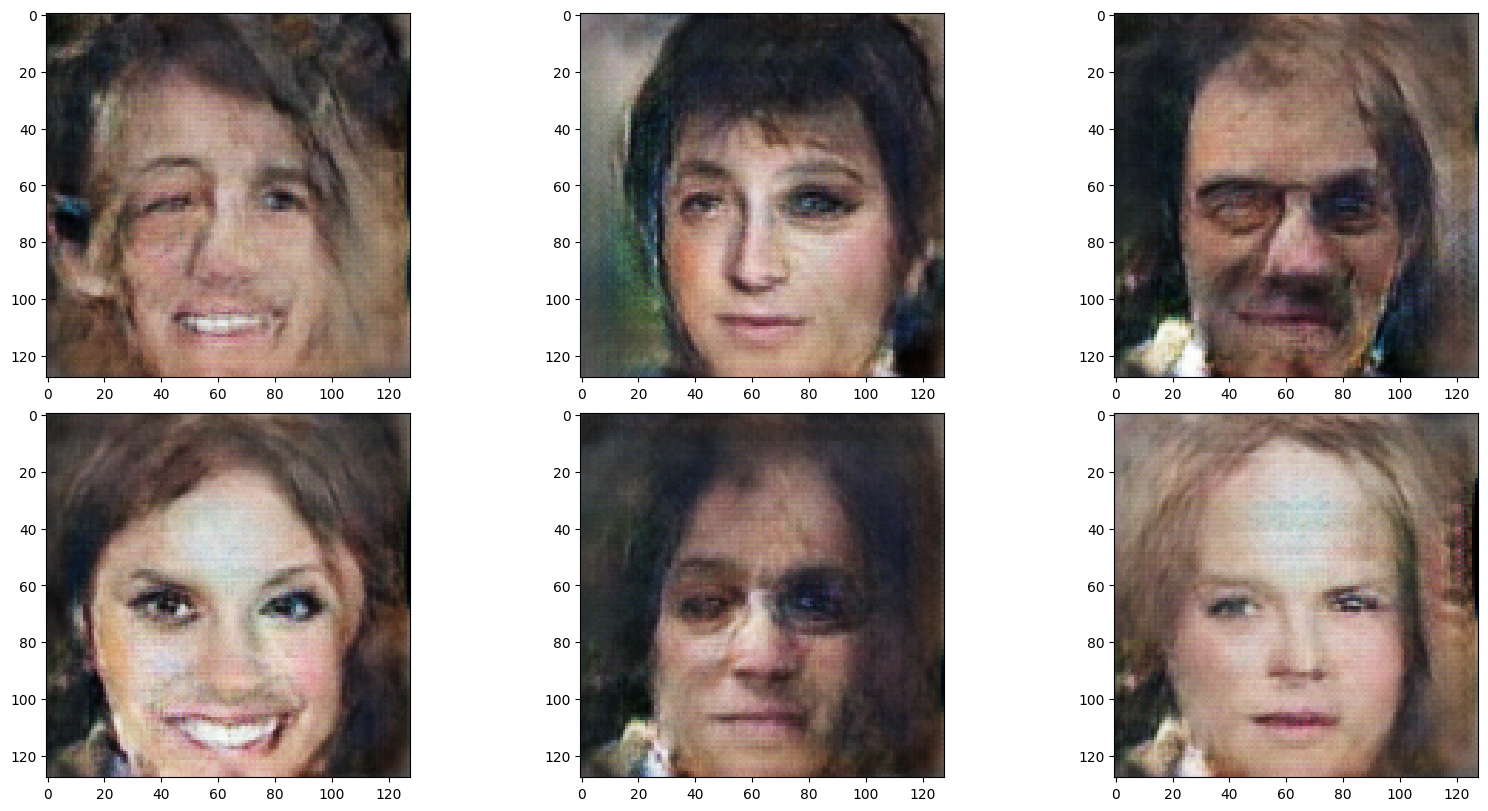

 学习进度：40.000 %

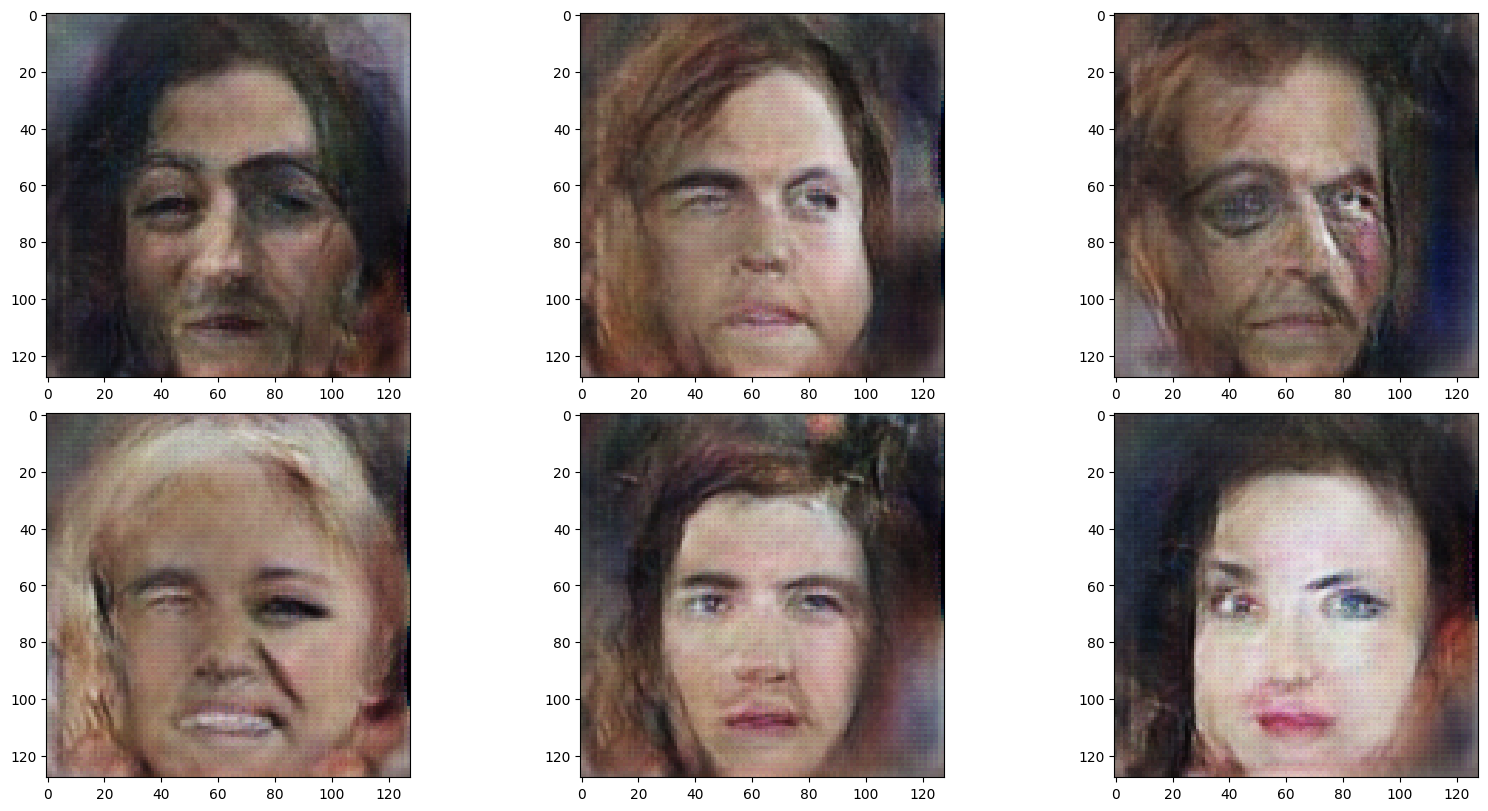

 学习进度：46.667 %

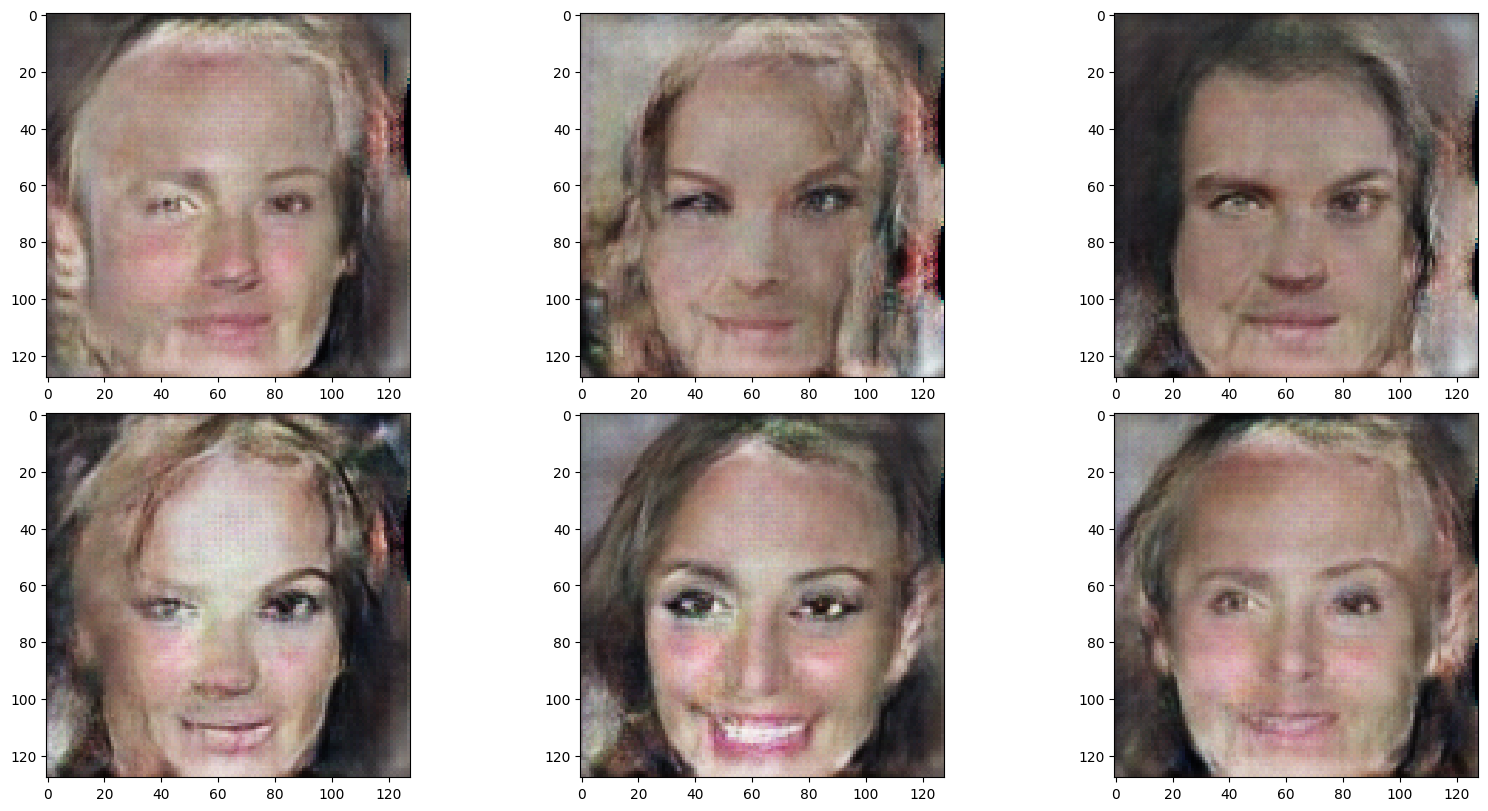

 学习进度：53.333 %

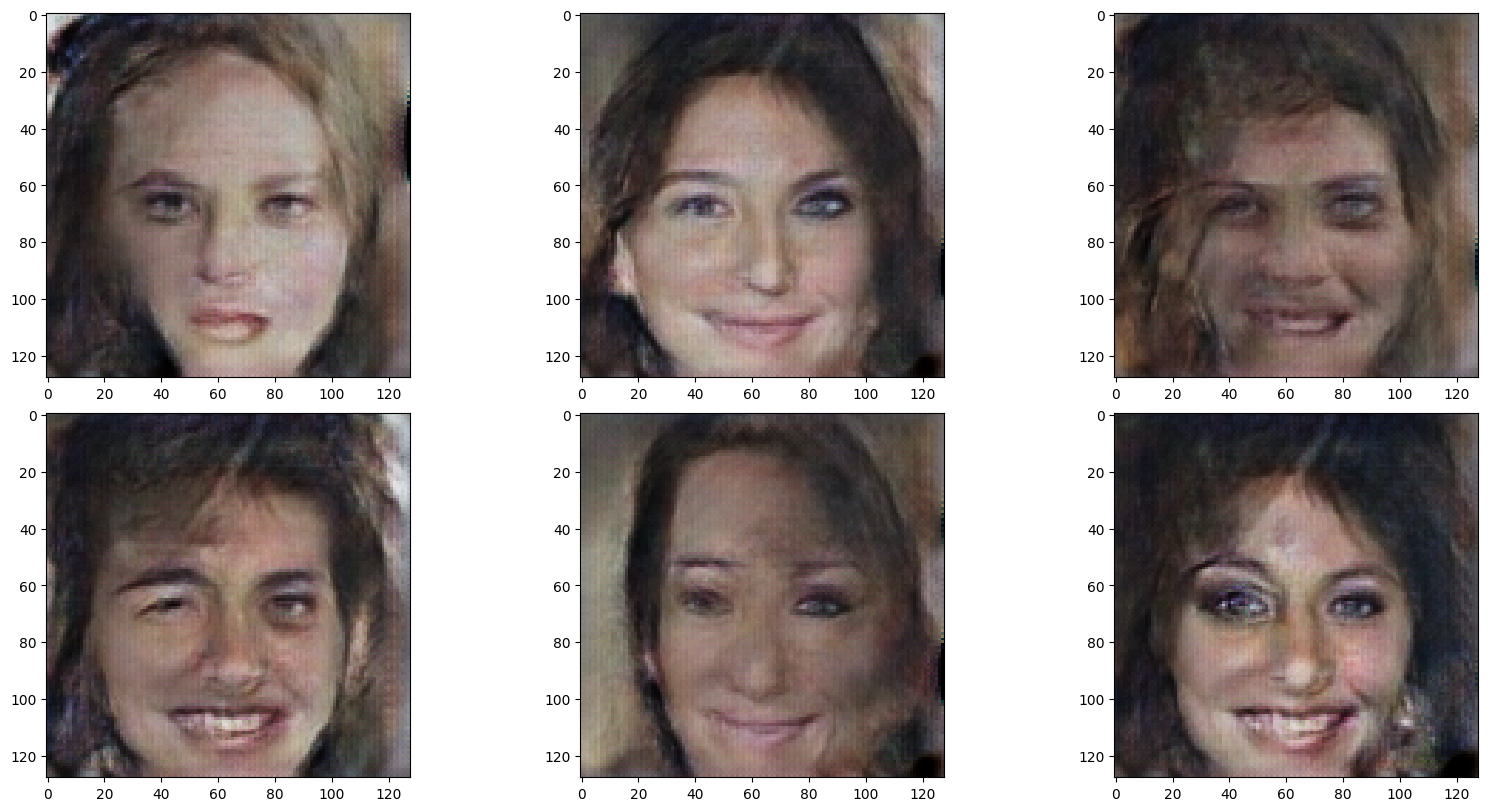

 学习进度：60.000 %

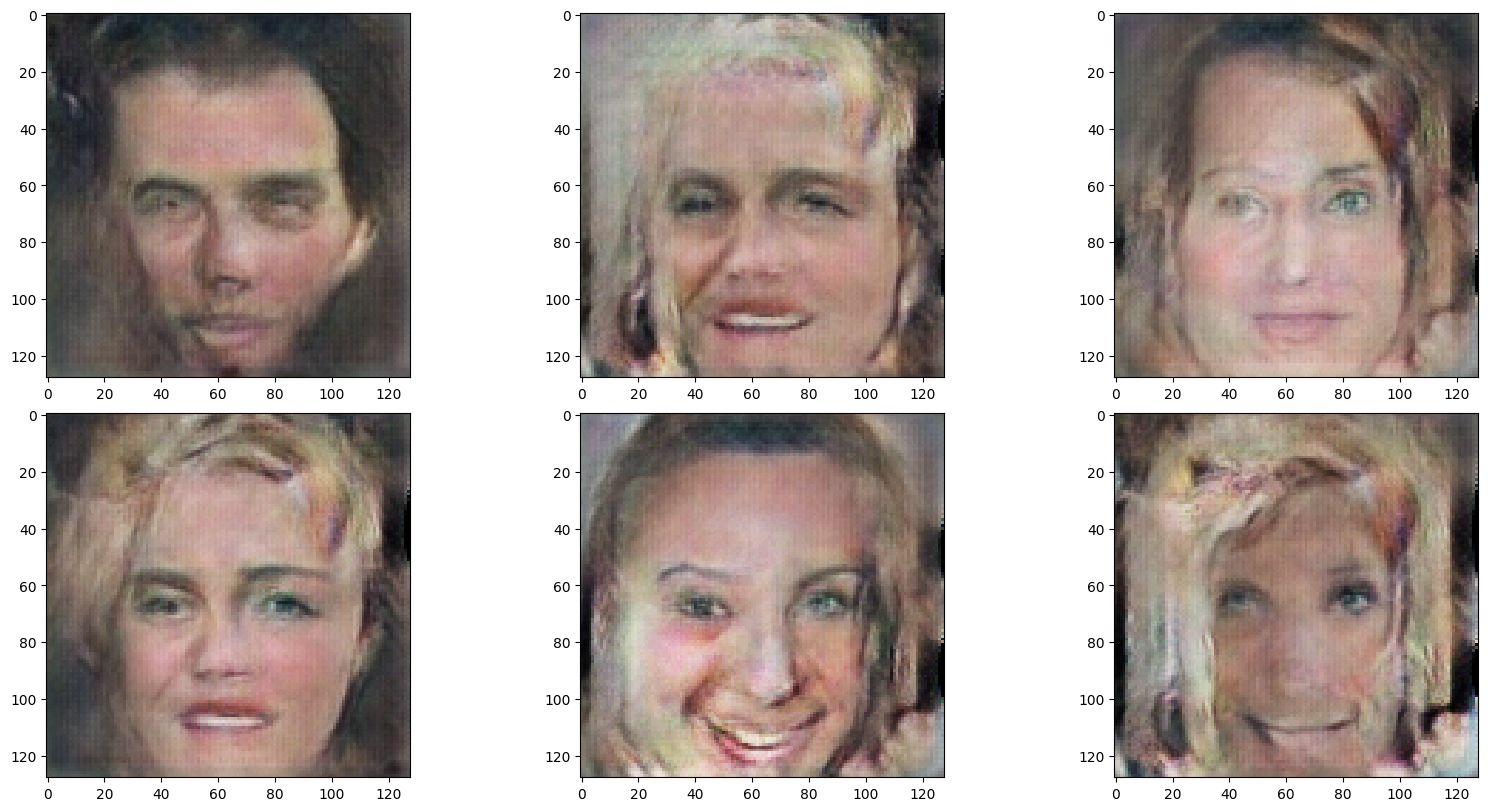

 学习进度：66.667 %

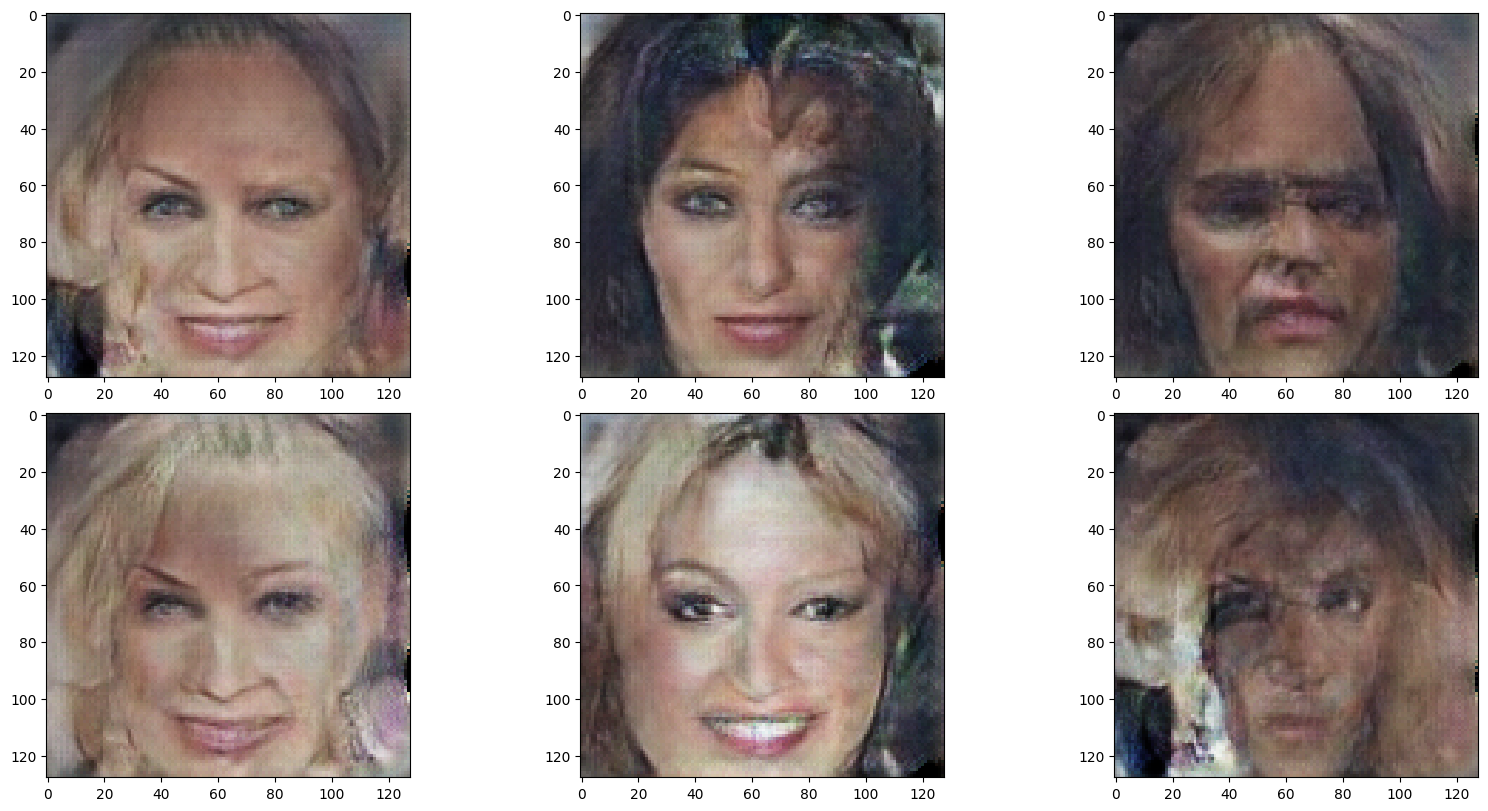

 学习进度：73.333 %

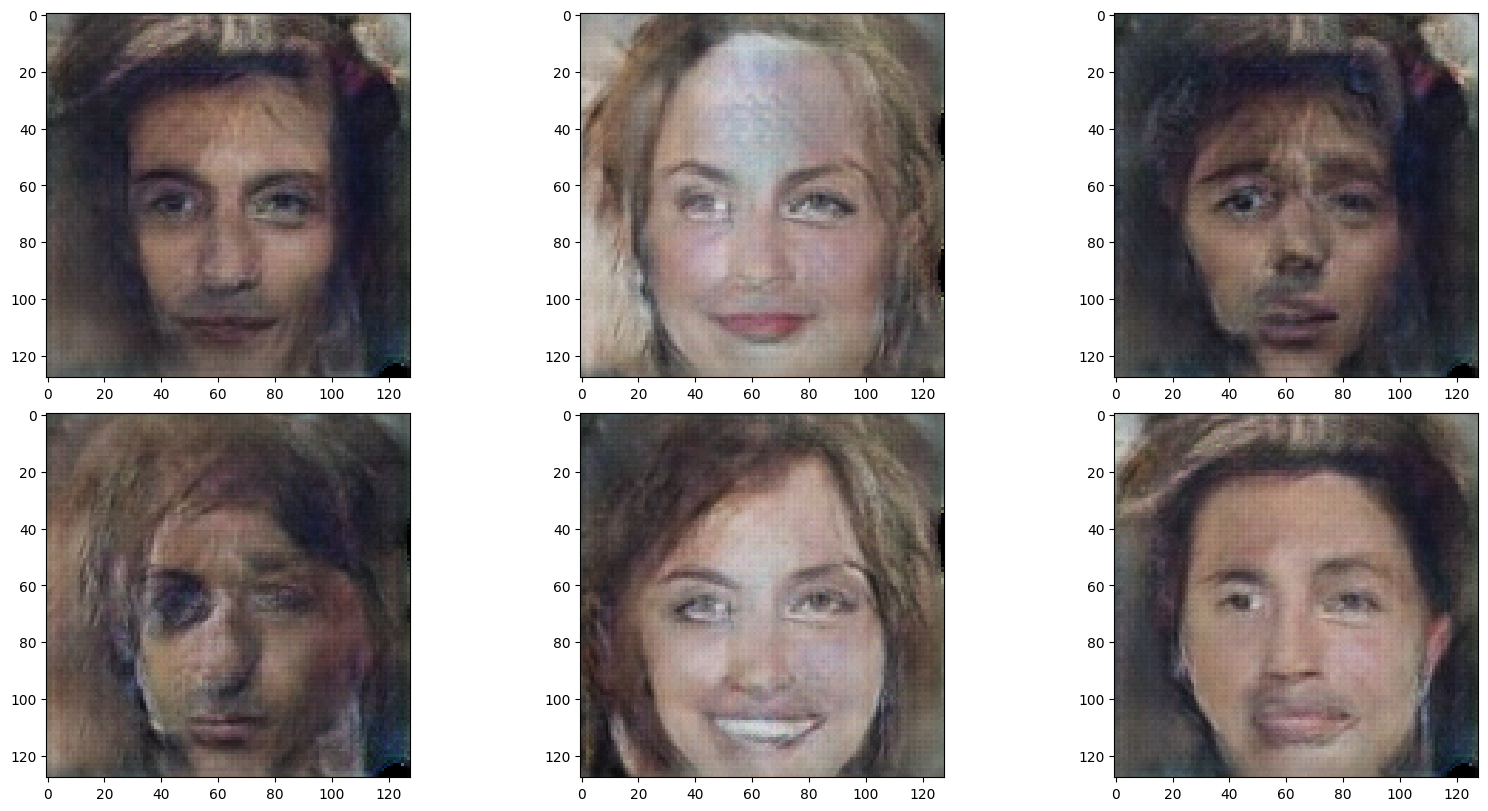

 学习进度：80.000 %

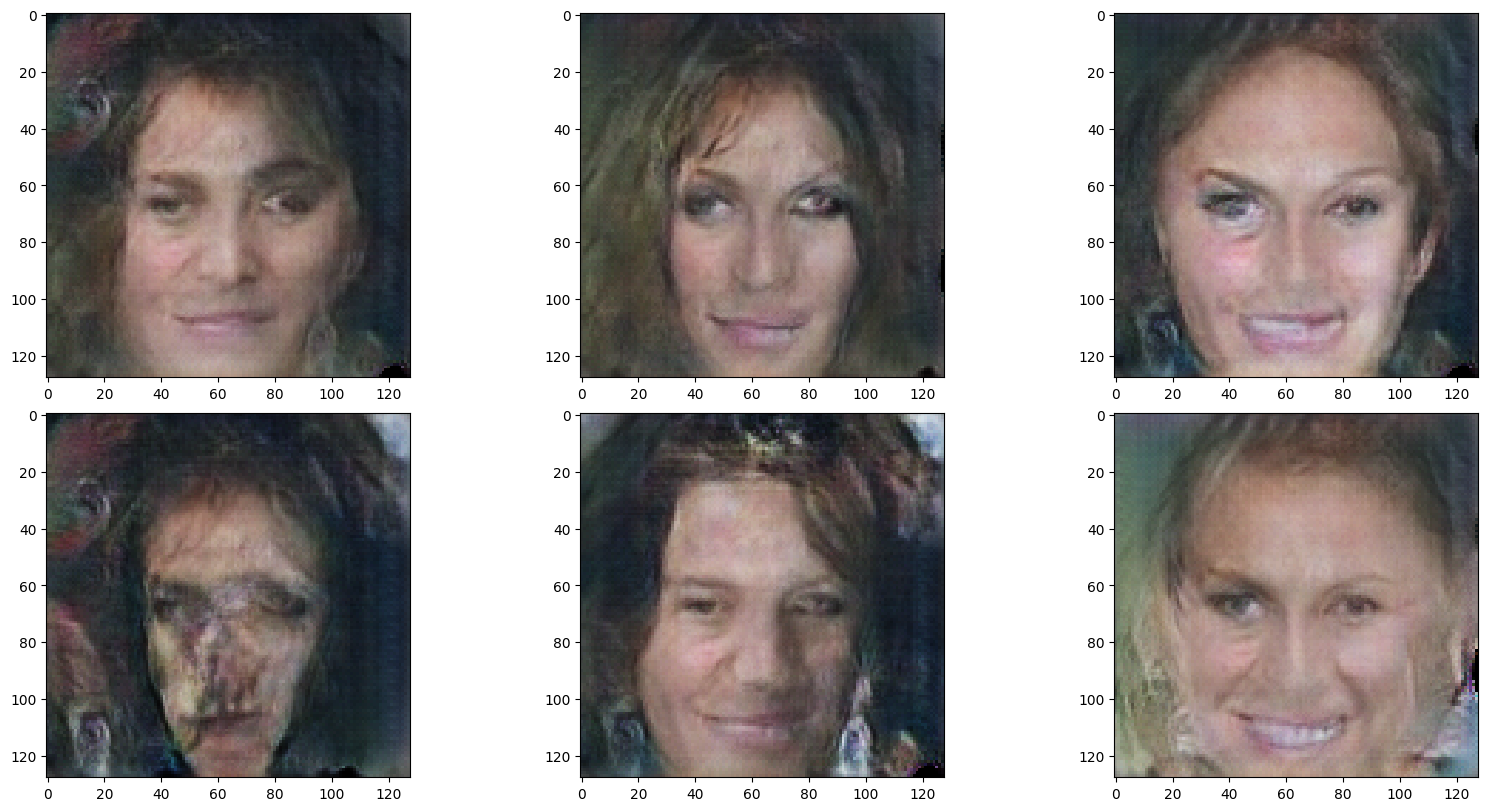

 学习进度：86.667 %

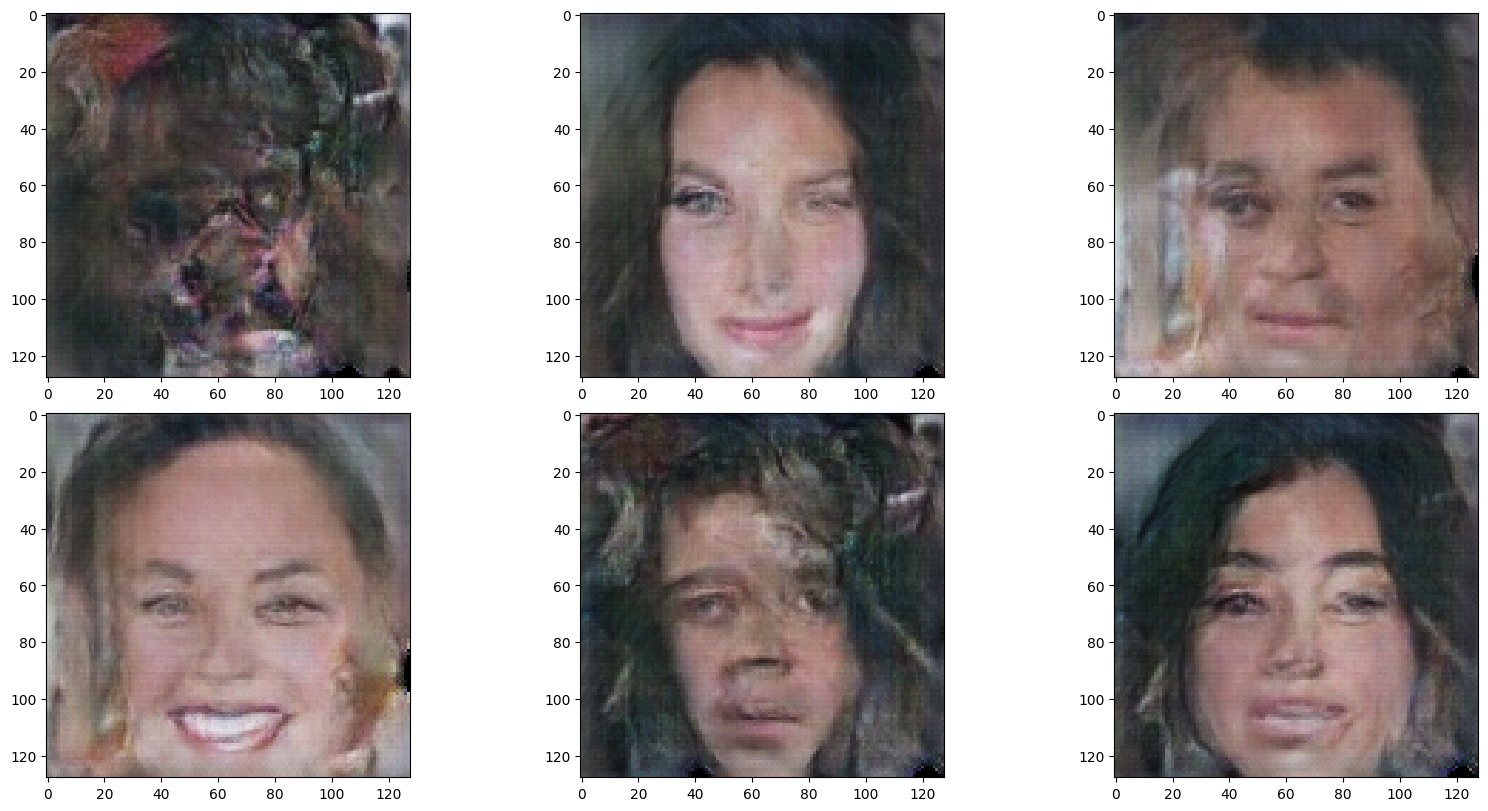

 学习进度：93.333 %

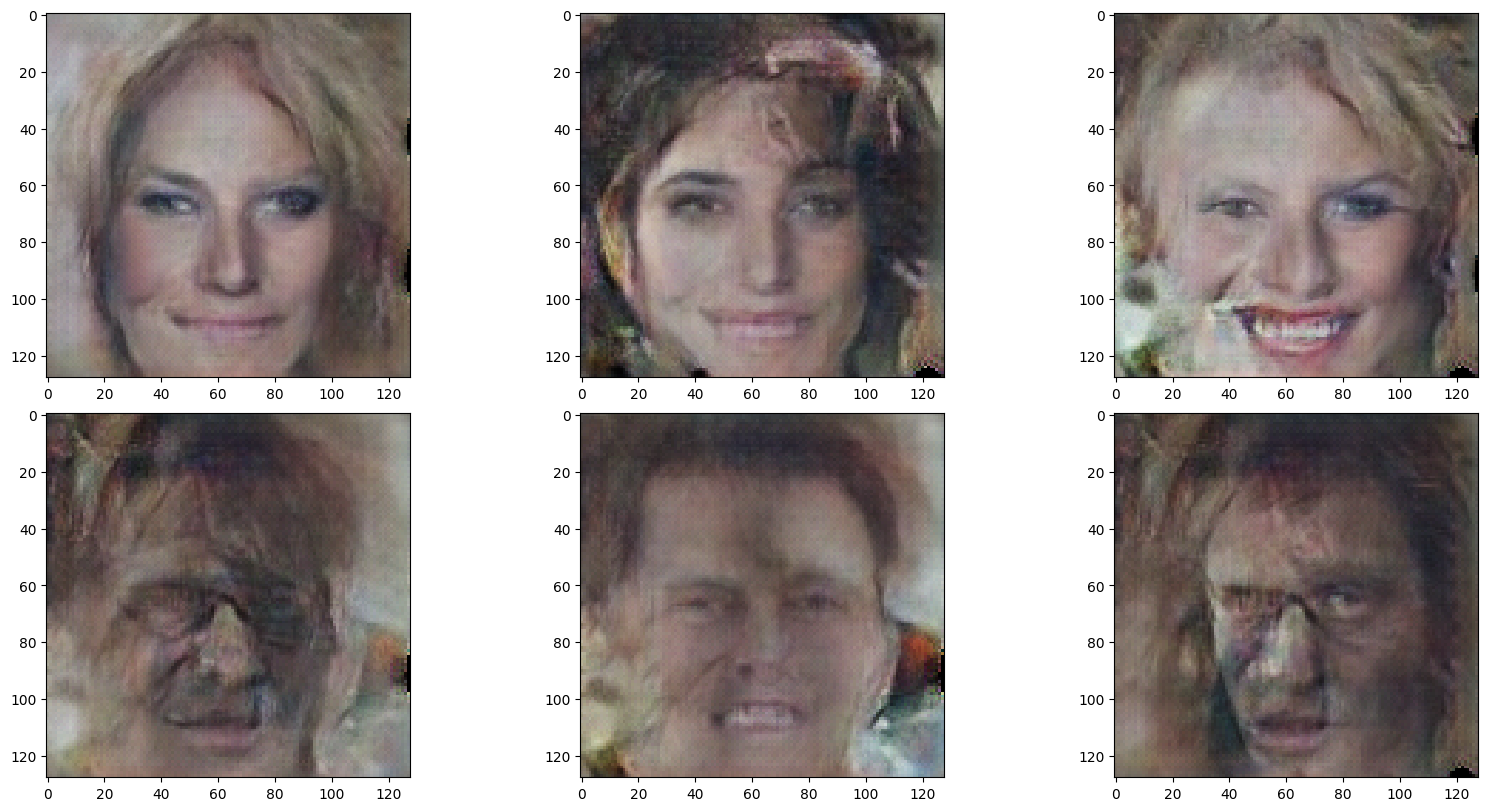


======= 训练完成 =======



In [28]:
# 开启训练
D.train()                 
G.train() 
print("======= 开始训练 =======\n")
for e in range(epochs):
    if e%1==0:    
        print("\r", "学习进度：{:.3f} %".format(e*100/epochs), end='', flush=True)

    for i, data in enumerate(train_data_loader, 0):
        inputs, _ = data   
        if i >= 20000: break # 训练20000次后停止训练
        
        # 用正确值训练判别器
        D.NN_train(inputs.to(device), right_lalel) # 正确值为1

        # 用 G 生成的错误值训练判别器
        inputs_G = G(torch.randn(size, device=device)).detach() # 生成的错误值
        D.NN_train(inputs_G, error_lalel) # 错误值为0

        # 用 G 生成的正确值训练生成器
        G.NN_train(D, torch.randn(size, device=device), right_lalel) # 正确值为1
    
    if e%1==0:
        # 开启评估
        D.eval()                 
        G.eval()
        plt_G()
        # 开启训练
        D.train()                 
        G.train() 

print("\n======= 训练完成 =======\n")

#### 开始评估训练效果

In [29]:
# 开启评估
D.eval()                 
G.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=363, bias=True)
    (1): GELU(approximate='none')
    (2): Unflatten(dim=0, unflattened_size=(1, 3, 11, 11))
    (3): ConvTranspose2d(3, 256, kernel_size=(8, 8), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): ConvTranspose2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
    (9): ConvTranspose2d(256, 3, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
)

In [30]:
progress_D = D.progress
progress_G = G.progress

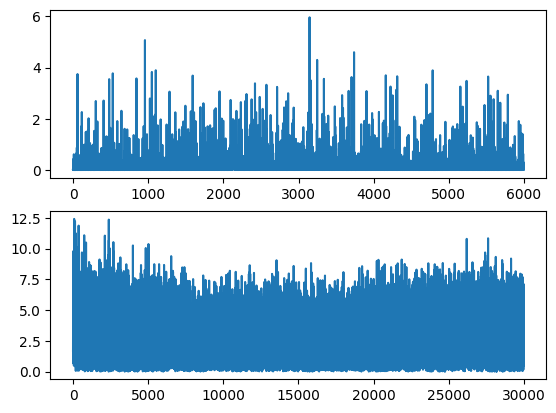

In [31]:
plt.subplot(2, 1, 1)
plt.plot(progress_D)

plt.subplot(2, 1, 2)
plt.plot(progress_G)
plt.show()

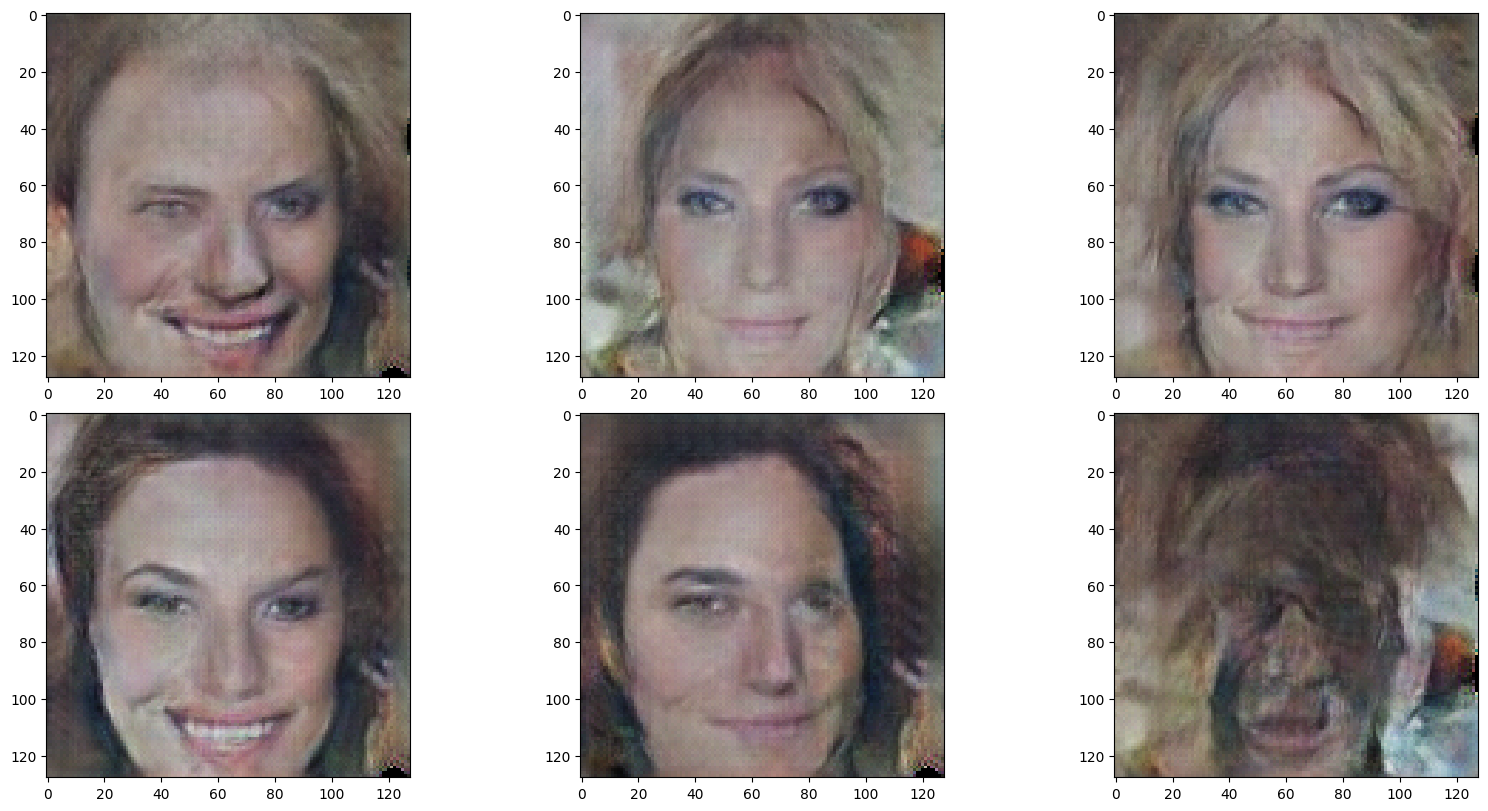

In [45]:
plt_G()